In [1]:
import os, numpy as np
from google.colab import drive

drive.mount('/content/drive/')
main_dir = os.path.dirname("/content/drive/MyDrive/colab_img/")

img_count = 0

Mounted at /content/drive/


####Definitions
<a name="definitions"></a>

In [ ]:
!pip install MediaPipe
import cv2, mediapipe as mp
from google.colab.patches import cv2_imshow
from drive.MyDrive.colab_img import face_mesh_connections

unrecognized = []

#eyes and lips specs
left_eye_idxs = set( [ i[0] for i in list(face_mesh_connections.FACEMESH_LEFT_EYE) ])
right_eye_idxs = set( [ i[0] for i in list(face_mesh_connections.FACEMESH_RIGHT_EYE) ])
lips_idxs = set( [ i[0] for i in list(face_mesh_connections.FACEMESH_LIPS) ])

crop_px_offset = (5,5)
crop_size = IMG_SIZE = (128, 128)

####Helper functions
<a name="helper"></a>

In [ ]:
#Utilizzato solo in "Facemesh and traits"
def get_bbox_coordinates(px_coords, offset):
    min_x = min([i[0] for i in px_coords])
    min_y = min([i[1] for i in px_coords])
    max_x = max([i[0] for i in px_coords])
    max_y = max([i[1] for i in px_coords])
    return [ min_y - offset[1] , max_y + offset[1] , min_x - offset[0] , max_x + offset[0] ]    


# Traccia un quadrato a partire dal lato più lungo del rettangolo che contiene l'occhio
def get_square_bbox(px_coords, offset):
    min_x = min([i[0] for i in px_coords])
    min_y = min([i[1] for i in px_coords])
    max_x = max([i[0] for i in px_coords])
    max_y = max([i[1] for i in px_coords])

    diff = (max_x - min_x) - (max_y - min_y)
    if diff > 0:
        return [ min_y -int(diff/2) -offset[1] , max_y +int(diff/2) +offset[1] , min_x -offset[0] , max_x +offset[0] ]
    else:
        return [ min_y -offset[1] , max_y +offset[1] , min_x -offset[0] -int(diff/2) , max_x +int(diff/2) +offset[1] ]


#Utilizzato solo in "Facemesh and traits"
def write_boundings(image, img_landmarks):
    eyes_pxs_offset = (10,10)
    mouth_pxs_offset = (20,20)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    if img_landmarks.multi_face_landmarks :
        #shows landmarks IDs
        cnt = 0
        right_eye_coords = []
        left_eye_coords = []
        lips_coords = []

        for data_point in img_landmarks.multi_face_landmarks:
            for coords in data_point.landmark:
                px_location = mp.solutions.drawing_utils._normalized_to_pixel_coordinates(coords.x, coords.y, image.shape[1], image.shape[0])
                if px_location is not None:
                    if cnt in left_eye_idxs:
                        left_eye_coords.append(px_location)
                        cv2.circle(image,px_location,2,(255,0,0),2)
                    elif cnt in right_eye_idxs:
                        right_eye_coords.append(px_location)
                        cv2.circle(image,px_location,2,(0,255,0),2)
                    elif cnt in lips_idxs:
                        lips_coords.append(px_location)
                        cv2.circle(image,px_location,2,(0,0,255),2)
                cnt = cnt + 1

        #update bounding box coordinates
        if right_eye_coords:
            coord = get_bbox_coordinates(right_eye_coords, eyes_pxs_offset)
            tl_right_eye = ( coord[2], coord[1] )
            br_right_eye = ( coord[3], coord[0] )
            cv2.rectangle(image,tl_right_eye,br_right_eye,(255,0,0)) 
        if left_eye_coords:
            coord = get_bbox_coordinates(left_eye_coords, eyes_pxs_offset)
            tl_left_eye = ( coord[2], coord[1] )
            br_left_eye = ( coord[3], coord[0] )
            cv2.rectangle(image,tl_left_eye,br_left_eye,(255,0,0))
        if lips_coords:
            coord = get_bbox_coordinates(lips_coords, mouth_pxs_offset)
            tl_lips = ( coord[2], coord[1] )
            br_lips = ( coord[3], coord[0] )
            cv2.rectangle(image,tl_lips,br_lips,(255,0,0))
    return image


def count_img(folder):
    img_count = 0
    for root, dirs, files in os.walk(folder):
        img_count += len(files)
    return str(img_count)


def how_many_img():
    trim_open = int( count_img("/content/drive/MyDrive/colab_img/TRIM/open_eye/") )
    trim_closed = int( count_img("/content/drive/MyDrive/colab_img/TRIM/closed_eye/") )
    lips = int( count_img("/content/drive/MyDrive/colab_img/TRIM/lips/") )
    man_img = int(count_img("/content/drive/MyDrive/colab_img/man/"))
    woman_img = int(count_img("/content/drive/MyDrive/colab_img/woman/"))
    print("Images for MAN: " + str(man_img) )
    print("Images for WOMAN: " + str(woman_img) )
    print("\nOpen eye elements: " + str(trim_open) )
    print("Closed eye elements: " + str(trim_closed) )
    print("Lips elements: " + str(lips) )
    print("\nTotal downloaded img: " + str(man_img + woman_img))
    print("Trainable img: " + str(trim_open + trim_closed + lips))


def Face_Recognition(img):
    with mp.solutions.face_mesh.FaceMesh( static_image_mode = True,
                                        max_num_faces = 2,
                                        min_detection_confidence = 0.5)  as face_mesh:
        if( isinstance(img, str) ): 
            try: 
                cv2_img = cv2.imread(img)
            except:
                print("Can't convert image to CV2 object -> deleting "+ str(img), end="\n\n")
                unrecognized.append(img)
                return 0  #avoid processing if can't convert to cv2 object
        elif( isinstance(img, np.ndarray) ):
            cv2_img = img
        else:   return 0  #avoid processing if method called with invalid image object (not string path nor cv2 object)
        

        ##image has been converted to cv2 img object
        try:
            results = face_mesh.process(cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB))
        except:
            print("Can't process image in FaceMesh -> deleting "+ str(img), end="\n\n")
            unrecognized.append(img)
        else:   #avoid continuing if can't generate mesh
            if not results.multi_face_landmarks:
                print("No landmarks in face -> deleting "+ str(img), end="\n\n")
                unrecognized.append(img)
            else:
                cnt = 0 #shows landmarks IDs
                right_eye_coords = []
                left_eye_coords = []
                lips_coords = []
                for data_point in results.multi_face_landmarks:
                    for coords in data_point.landmark:
                        px_location = mp.solutions.drawing_utils._normalized_to_pixel_coordinates(coords.x, coords.y, cv2_img.shape[1], cv2_img.shape[0])
                        if px_location is not None:
                            if cnt in left_eye_idxs:
                                left_eye_coords.append(px_location)
                            elif cnt in right_eye_idxs:
                                right_eye_coords.append(px_location)
                            elif cnt in lips_idxs:
                                lips_coords.append(px_location)
                        cnt = cnt + 1
                face_elements = [left_eye_coords, right_eye_coords, lips_coords]
                return face_elements
    return 0

def Crop_to_Square(image, element_coord, crop_px_offset = (5,5), crop_size = (128, 128)):
    crop_coord = get_square_bbox(element_coord, crop_px_offset)  # update bounding box coordinates to square bBox
    #                      min_y      max_y             min_x       max_x
    temp_img = image[ crop_coord[0]:crop_coord[1] , crop_coord[2]:crop_coord[3] ]   #crop img to square bBox
    try:
        return cv2.resize(temp_img, (crop_size[0], crop_size[1]) )    #resize to allowed MobileNetV2 img size
    except:
        print("Can't trim img")
    return 0

---
##Creazione stock di immagini

In [ ]:
!pip install google-search-results
from serpapi import GoogleSearch

#lista da popolare
images_results = []

for x in range(9):
    params = {
        "q": "black woman closed eye",
        "tbm": "isch",
        "ijn": x,
        "api_key": "e328f794d5ac4118e260de595b26f0042e14b5418c0c4e60a2129b0446c33610"
    }
    search = GoogleSearch(params)
    results = search.get_dict()
    images_results = images_results + results['images_results']

print(len(images_results))

#man eyes
#man face eye
#man face
#man smiling
#black man smiling
#black man face
#eyes wide open man
#wide eye man
##man closed eyes
##man eye blink
##man closed eye
##man eyes shut
##black man closed eye

In [ ]:
# Save images in the right folder

os.chdir("/content/drive/MyDrive/colab_img/woman/closed_eye")

for index, item in enumerate(images_results):
    url = item.get("original")
    !wget  "$url" -O "./$"
    index += 1

# frees up memory at completion
images_results = []

---

---
##Image processing

####Face mesh and traits

In [ ]:
# Prepare DrawingSpec for drawing the face landmarks later.
drawing_spec = mp.solutions.drawing_utils.DrawingSpec(thickness=2, circle_radius=1)

#convert img to cv2 element
number = 5021  #start picture
for item in range(2):
    print("Analyzing:\t /content/drive/MyDrive/colab_img/man/full_face/open_eye/" + str(number + item) )
    image_bundle[ str(number + item) ] = cv2.imread("/content/drive/MyDrive/colab_img/man/full_face/open_eye/" + str(number+item) + ".jpg")

with mp.solutions.face_mesh.FaceMesh( static_image_mode = True,
                            max_num_faces = 2,
                            min_detection_confidence = 0.5)  as face_mesh:
    unrecognized = []
    for fullName, image in image_bundle.items():
        try: # Convert the BGR image to RGB and process it with MediaPipe Face Mesh.
            results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        except:
            print("Can't recognize face -> deleting "+ str(fullName), end="\n\n")
            unrecognized.append(fullName)
        else:
            if not results.multi_face_landmarks:
                print("No landmarks in face -> deleting "+ str(fullName), end="\n\n")
                unrecognized.append(fullName)
            else:
                # Draw face landmarks of each face
                annotated_image = image.copy()
                for face_landmarks in results.multi_face_landmarks:
                    mp.solutions.drawing_utils.draw_landmarks( 
                                image = annotated_image,
                                landmark_list = face_landmarks,
                                connections = mp.solutions.face_mesh.FACEMESH_TESSELATION,
                                landmark_drawing_spec = drawing_spec,
                                connection_drawing_spec = drawing_spec )
                print(f'Calculating face landmarks for: {fullName}')
                cv2_imshow(annotated_image)
                marked_image = write_boundings(image, results)
                cv2_imshow(marked_image)

    print("TOTAL images: ", " ")
    count_img(main_dir)

---
####Face recognition + crop

In [ ]:
eye_savePath = main_dir + "/TRIM/open_eye/"

for subdir, dirs, files in os.walk(main_dir + "/man/open_eye"):
    for filename in files:
        subdirectoryPath = os.path.relpath(subdir, main_dir)
        fullName = str(main_dir+"/"+subdirectoryPath+"/"+filename)
        print("Analizing: " + fullName)
        
        face_elements = Face_Recognition(fullName)
        for face_item_coord in face_elements:
            if face_item_coord:
                cropped_img = Crop_to_Square(fullName, face_item_coord, crop_px_offset, crop_size)
                if not cropped_img: #avoid attempt to save if can't crop image
                    try:
                        if face_item_coord == face_elements[2]: #is the mouth
                            cv2.imwrite( main_dir +"/TRIM/lips/"+ str(img_count) + "_lips.jpg" , cropped_img)
                            print("Writing:  " +main_dir+ "/TRIM/lips/" +str(img_count) + "_lips.jpg")
                        else: #is an eye
                            cv2.imwrite( eye_savePath + str(img_count) + "_eye.jpg" , cropped_img)
                            print("Writing:  "+ eye_savePath + str(img_count) + "_eye.jpg")
                        img_count +=1
                    except:
                        print("Can't write img: " +str(image))
                        continue
            else:
                continue

Backup downloaded image dataset

In [ ]:
#zip all trim images and then unpack to local filesystem
how_many_img()
!zip -rv ./drive/MyDrive/colab_img/TRIM/trim_images.zip ./drive/MyDrive/colab_img/TRIM/

---
## Neural net configuration

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory as img_dataset_from_dir
import matplotlib.pyplot as plt

!mkdir /content/trim_img_dataset
!unzip /content/drive/MyDrive/colab_img/TRIM/trim_images.zip -d /content/trim_img_dataset/ #local filesystem

IMG_SIZE = (128, 128) #crop_size
BATCH_SIZE = 32

train_dir = "/content/trim_img_dataset"

train_dataset = img_dataset_from_dir(   train_dir,
                                        shuffle = True,
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        validation_split = 0.2,
                                        subset = "training",
                                        seed = 123
                                        )

validation_dataset = img_dataset_from_dir( train_dir,
                                        shuffle = True,
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        validation_split = 0.2,
                                        subset = "validation",
                                        seed = 123
                                        )


val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)

validation_dataset = validation_dataset.skip(val_batches // 5)

print('\nNumber of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

---
Preview classes

['closed_eye', 'open_eye']


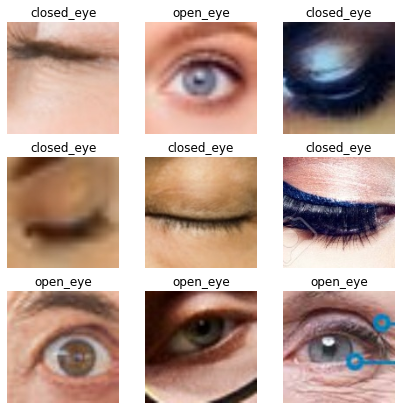

In [ ]:
class_names = train_dataset.class_names
print(class_names)

plt.figure(figsize=(7, 7))
l = train_dataset.take(1)

for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

---
Performance settings

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

Data augmentation

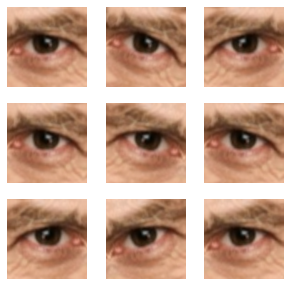

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.05),
])

#preview
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(5, 5))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

---
<h4>Rescale pixel values</h4>

The base model &nbsp; *tf.keras.applications.MobileNetV2* &nbsp; expects pixel values in &nbsp;[-1, 1]&nbsp; but images are in range &nbsp;[0, 255].  
Need to rescale with preprocessing method included in the model.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

####Base model creation
Creating the base model starting from the MobileNet V2 model developed by Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes of classes. 

- Selecting the "bottleneck layer" of MobileNet V2 to use for feature extraction.  
It features retain more generality as compared to the final/top layer.

- Instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet.  
By specifying the &nbsp; *include_top=False* &nbsp; argument, will be loaded a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
IMG_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet')

# convert 160x160x3 image into a 5x5x1280 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print("Shape:  " + str(feature_batch.shape) )

9420800/9406464 [==============================] - 0s 0us/step
Shape:  (32, 4, 4, 1280)


---
## Feature extraction

It's important to freeze the convolutional base before you compile and train the model, by setting &nbsp; *layer.trainable = False*  
It prevents the weights in a given layer from being updated during training. 
MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.  

Doing so, lets the BatchNormalization layer running in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [ ]:
base_model.trainable = False
#base_model.summary()

<h3>Classification Head</h3>

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a &nbsp;*tf.keras.layers.GlobalAveragePooling2D*&nbsp; layer to convert the features to a single 1280-element vector per image.  

Then apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logic, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 1)


Building a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. 
Since our model contains a BatchNormalization layer is used *training=False*

In [ ]:
inputs = tf.keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.imagenet_utils.preprocess_input(x, data_format="channels_last", mode='tf')
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

---
<h3>Compiling</h3>

Compile the model before training it.  
Since there are two classes, use a binary cross-entropy loss with *from_logits=True* since the model provides a linear output.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = ['accuracy'])
#model.summary()

#The 2.5M parameters in MobileNet are frozen, but there are 1.2K trainable parameters in the Dense layer. 
#These are divided between two tf.Variable objects, the weights and biases.
len(model.trainable_variables)

2

<h4>Train the model</h4>

After training for 10 epochs, good accuracy should reflect on the validation set.

In [ ]:
loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

104/104 [==============================] - 38s 338ms/step - loss: 0.9988 - accuracy: 0.3595
initial loss: 1.00
initial accuracy: 0.36


In [ ]:
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs = initial_epochs,
                    validation_data = validation_dataset)

Epoch 1/10
518/518 [==============================] - 224s 425ms/step - loss: 0.3838 - accuracy: 0.8144 - val_loss: 0.1800 - val_accuracy: 0.9461
Epoch 2/10
518/518 [==============================] - 217s 419ms/step - loss: 0.1631 - accuracy: 0.9380 - val_loss: 0.1245 - val_accuracy: 0.9595
Epoch 3/10
518/518 [==============================] - 216s 417ms/step - loss: 0.1265 - accuracy: 0.9523 - val_loss: 0.1081 - val_accuracy: 0.9610
Epoch 4/10
518/518 [==============================] - 216s 417ms/step - loss: 0.1109 - accuracy: 0.9574 - val_loss: 0.0955 - val_accuracy: 0.9667
Epoch 5/10
518/518 [==============================] - 215s 416ms/step - loss: 0.1010 - accuracy: 0.9612 - val_loss: 0.0887 - val_accuracy: 0.9670
Epoch 6/10
518/518 [==============================] - 222s 429ms/step - loss: 0.0959 - accuracy: 0.9628 - val_loss: 0.0847 - val_accuracy: 0.9679
Epoch 7/10
518/518 [==============================] - 219s 422ms/step - loss: 0.0894 - accuracy: 0.9650 - val_loss: 0.0794 -

####Learning curves

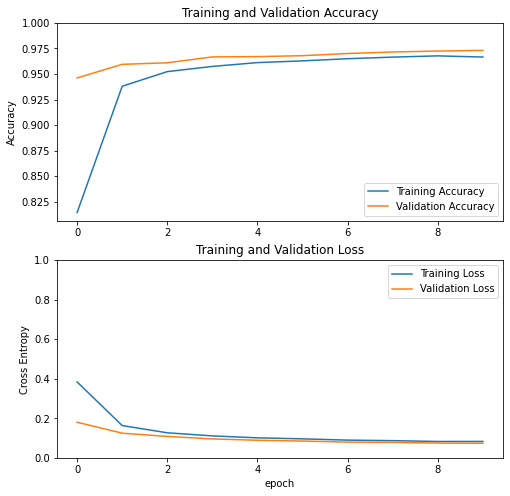

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

---
##Fine tuning
In the feature extraction experiment, a few layers on top of an MobileNet V2 base model has been trained. 
The weights of the pre-trained network were not updated during training.

A way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.  
<br>
####Un-freeze the top layers of the model

In [ ]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


---
<h3>Compile the model</h3>

Using a lower learning rate at this stage since we are training a much larger model and want to readapt the pretrained weights.  
Otherwise, model could overfit very quickly.

In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate/10),
              metrics = ['accuracy'])

#model.summary()
len(model.trainable_variables)

2

<h3>Improve accuracy</h3>

If you trained to convergence earlier, this step will improve  accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs = total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = validation_dataset)

Epoch 10/20
518/518 [==============================] - 220s 418ms/step - loss: 0.0797 - accuracy: 0.9691 - val_loss: 0.0726 - val_accuracy: 0.9722
Epoch 11/20
518/518 [==============================] - 213s 411ms/step - loss: 0.0792 - accuracy: 0.9694 - val_loss: 0.0726 - val_accuracy: 0.9731
Epoch 12/20
518/518 [==============================] - 215s 415ms/step - loss: 0.0806 - accuracy: 0.9687 - val_loss: 0.0735 - val_accuracy: 0.9728
Epoch 13/20
518/518 [==============================] - 215s 415ms/step - loss: 0.0782 - accuracy: 0.9688 - val_loss: 0.0723 - val_accuracy: 0.9737
Epoch 14/20
518/518 [==============================] - 214s 414ms/step - loss: 0.0787 - accuracy: 0.9698 - val_loss: 0.0726 - val_accuracy: 0.9737
Epoch 15/20
518/518 [==============================] - 216s 416ms/step - loss: 0.0772 - accuracy: 0.9691 - val_loss: 0.0737 - val_accuracy: 0.9734
Epoch 16/20
518/518 [==============================] - 212s 409ms/step - loss: 0.0803 - accuracy: 0.9685 - val_loss: 0

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. If the validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.

After fine tuning the model nearly reaches 98% accuracy on the validation set.

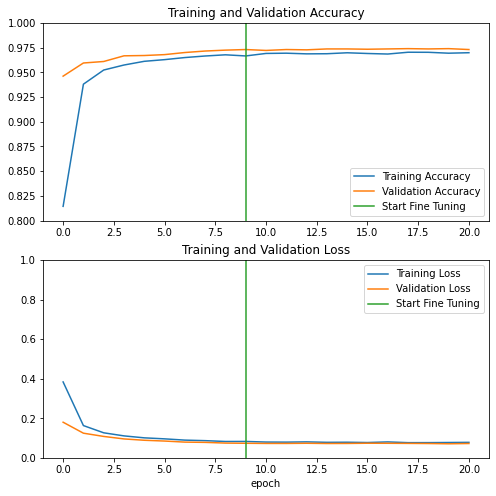

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

---
<h3>Evaluation</h3>
Verify model performance by using the test-set with never used (new) data

26/26 [==============================] - 8s 317ms/step - loss: 0.0704 - accuracy: 0.9712
Test accuracy : 0.9711538553237915
tf.Tensor(
[9.9963915e-01 5.2591562e-03 9.9999440e-01 8.9791566e-02 9.9999481e-01
 9.9997443e-01 1.5622377e-04 2.8675795e-04 2.0117760e-02 9.9999499e-01
 9.9591410e-01 9.9999928e-01 9.9333274e-01 5.2470607e-01 9.9937975e-01
 9.9987864e-01 9.9198341e-01 2.0171106e-03 9.9832058e-01 2.0288229e-02
 3.7518144e-04 9.8449600e-01 2.3040384e-02 2.2034407e-02 9.9999666e-01
 3.4123659e-04 9.1465890e-02 9.9953723e-01 9.9911153e-01 7.7383220e-03
 9.9999678e-01 9.9827105e-01], shape=(32,), dtype=float32)


Predictions:
 [1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1 1]
Labels:
 [1 0 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1 1]


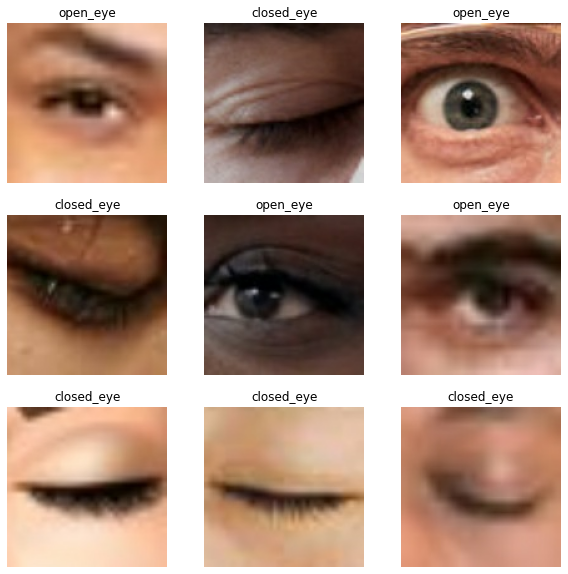

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
print(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('\n\nPredictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

####Prediction
Use the model to predict if an eye is opened or closed

tf.Tensor(
[9.9999976e-01 7.2620440e-01 9.9989939e-01 9.9994993e-01 9.9997669e-01
 9.9999940e-01 9.9999881e-01 9.8533934e-01 5.7486057e-02 9.9999142e-01
 9.7551978e-01 9.9984491e-01 9.0769863e-01 9.9987864e-01 8.6371928e-01
 9.9999797e-01 5.3372979e-04 2.1165520e-02 3.4856796e-04 2.1649450e-01
 1.4063954e-02 9.9999893e-01 1.5306473e-04 1.6956031e-03 9.5168424e-01
 7.5547397e-03 9.9994791e-01 9.9998343e-01 9.9999928e-01 1.5117228e-03
 9.9997008e-01 9.5363498e-01], shape=(32,), dtype=float32)
Predictions:
 [1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 1]
Labels:
 [1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 1]


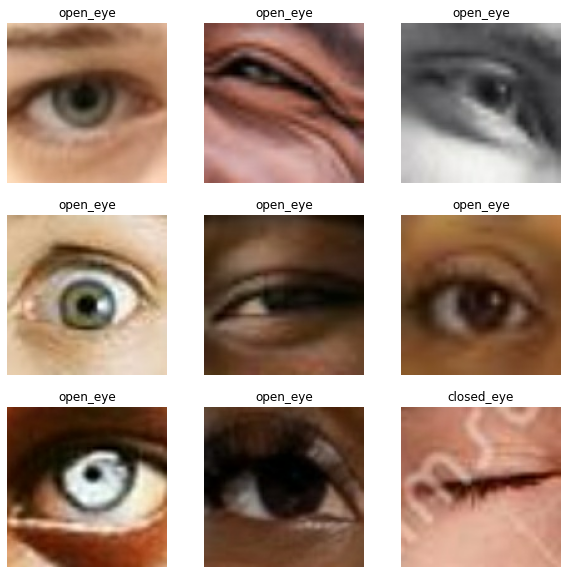

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
print(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
#Evaluate final results using confusion matrix
confusion_m = tf.math.confusion_matrix(labels = label_batch , predictions = predictions)
print(confusion_m)
accuracy = np.trace(confusion_m) / float(np.sum(confusion_m))
misclass = 1 - accuracy
print("OA: ",accuracy)

tf.Tensor(
[[10  0]
 [ 0 22]], shape=(2, 2), dtype=int32)
OA:  1.0


##Saving the model to run without re-training it

In [ ]:
model.save('/content/drive/MyDrive/colab_img/MODEL/eye_trained_model_20ep.h5', save_format='h5')
!zip -rv /content/drive/MyDrive/colab_img/MODEL/eye_trained_model_20ep.h5.zip /content/drive/MyDrive/colab_img/MODEL
#!unzip eye_trained_model.h5.zip /content/drive/MyDrive/colab_img/MODEL/

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


  adding: content/drive/MyDrive/colab_img/MODEL/	(in=0) (out=0) (stored 0%)
  adding: content/drive/MyDrive/colab_img/MODEL/eye_trained_model_25ep.h5 	(in=9358192) (out=8438552) (deflated 10%)
total bytes=9358192, compressed=8438552 -> 10% savings


---
---

##Load trained model
<a name="model"></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
#!unzip -o /content/drive/MyDrive/colab_img/MODEL/eye_trained_model_20ep.h5.zip -d ./drive/MyDrive/colab_img/MODEL

model = keras.models.load_model('/content/drive/MyDrive/colab_img/MODEL/eye_trained_model_20ep.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                             

##Run model on a full video
<a name="video"></a>

Read video frames

In [ ]:
import cv2, numpy as np
from google.colab.patches import cv2_imshow

videoName = 'M'
!cp /content/drive/MyDrive/colab_img/$videoName\.mp4 ./
video = cv2.VideoCapture( "/content/"+ videoName +".mp4" )

success,image = video.read()
index = 1
ALL_FRAMES = []

while success:
    try:
        success,image = video.read()
        ALL_FRAMES.append( image )
        print('\nRead frame ',index, " ",success)
        cv2_imshow(image)

        index += 1
    except:
        print("Error reading frame", index)
        continue
else: print("End of video")

#cv2_imshow(ALL_FRAMES[47]) #M
cv2_imshow(ALL_FRAMES[27]) #G

####Predict video frame
[Run &nbsp;<i>Definitions</i>](#definitions)
<br>
[Run &nbsp;<i>Helper functions</i>](#helper)
<br>
[Load &nbsp;<i>Model</i>&nbsp; first](#model)

In [ ]:
from datetime import datetime

def Eye_Prediction(single_frame):
    img_gray = cv2.cvtColor(single_frame, cv2.COLOR_BGR2GRAY)
    img_r = np.zeros((1,img_gray.shape[0], img_gray.shape[1], 3))  
    for i in range(3):  
        img_r[0,:,:,i] = img_gray
        
    predictions = model.predict(img_r)
    #print(predictions)
    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(predictions)
    #print(predictions)
    predictions = predictions >= 0.5
    #print('Predictions:', predictions.numpy() )
    #print(predictions)
    
    return  predictions


VID_PREDICTIONS = np.zeros( (len(ALL_FRAMES)-1, 2) ) #skip video end delimiter
row = 0

start_time = datetime.now()
for index, frame in enumerate(ALL_FRAMES):
    print("Predicting frame ", index+1)
    face_items = Face_Recognition(frame)
    col = 0

    if face_items:
        for item in face_items:    
            if col == 2:    #skip mouth
                continue
            else:
                img = Crop_to_Square(frame, item)
                #print("SHAPE", Eye_Prediction(img)[0].shape)
                VID_PREDICTIONS[row,col] = Eye_Prediction(img)
                #cv2_imshow(img)
                #print(VID_PREDICTIONS[row,col])
                col +=1
    else:
        print("Can't detect face")
    row+=1

elapsed = datetime.now() - start_time
print("Execution time: ",elapsed)

<h4>Ground-Truth</h4>
<a name="ground"></a>


In [ ]:
ground_truth = np.genfromtxt("/content/drive/MyDrive/colab_img/" + videoName +".txt", delimiter=' ')
print("Ground_truth shape ", ground_truth.shape)
#print("\n", ground_truth)

VID_PREDICTIONS = np.array(VID_PREDICTIONS)
print("Prediction shape ", VID_PREDICTIONS.shape)
#print("\n", VID_PREDICTIONS)

Ground_truth shape  (131, 2)
Prediction shape  (131, 2)


<h4>Confusion Matrix</h4>

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

VID_PREDICTIONS = VID_PREDICTIONS.flatten() #reshade from Nx2 to (Mx1)
ground_truth = ground_truth.flatten()

results = confusion_matrix(ground_truth, VID_PREDICTIONS)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix = results)
conf_matrix.plot()

---
##TensorFlow Lite
[Load &nbsp;<i>Model</i>&nbsp; first](#model)<br>
<h4>Convert standard model to Lite version</h4>

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('/content/drive/MyDrive/colab_img/MODEL/eye_trained_model_20ep.tflite', 'wb') as file:
    file.write(tflite_model)

<h4>Load Lite model</h4>

In [ ]:
import tensorflow as tf

with open("/content/drive/MyDrive/colab_img/MODEL/eye_trained_model_20ep.tflite", 'rb') as file:
    tflite_model = file.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

<h4>Run Lite model on a video</h4>

[Read a video first](#video)

[Start Helper functions](#helper)[ and Definitions](#definitions)

In [ ]:
def Lite_Prediction(img):
    input_data = np.array(img, dtype=np.float32)
    input_data = np.expand_dims(input_data, axis=0)
    #print("input shape",input_data.shape)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])


LITE_PREDICTIONS = np.zeros( (len(ALL_FRAMES)-1, 2) ) #skip video end delimiter
row = 0

start_time = datetime.now()
for index, frame in enumerate(ALL_FRAMES):
    print("Predicting frame ", index+1)
    face_items = Face_Recognition(frame)
    col = 0
    
    if face_items:
        for item in face_items:    
            if col == 2:    #skip mouth
                continue
            else:
                img = Crop_to_Square(frame, item)
                p = Lite_Prediction(img)
                p = tf.nn.sigmoid(p)
                #print(p)
                p = p >= 0.5
                LITE_PREDICTIONS[row,col] = p
                col +=1
    else:
        print("Can't detect face")
    row+=1

elapsed_lite = datetime.now() - start_time
print("Execution time: ", elapsed_lite)

<h4>Confusion Matrix Lite and comparing</h4> 

[Create Ground-truth first](#ground)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

ground_truth = ground_truth.flatten() #reshade from Nx2 to (Mx1)
LITE_PREDICTIONS = LITE_PREDICTIONS.flatten() 

lite_results = confusion_matrix(ground_truth, LITE_PREDICTIONS)
lite_conf_matrix = ConfusionMatrixDisplay(confusion_matrix = lite_results)

lite_conf_matrix.plot()
conf_matrix.plot() #original model

print("MODEL EXECUTION TIME")
print("Lite: ", elapsed_lite)
print("Standard: ", elapsed)
print("\nTime gap: ", (elapsed-elapsed_lite) )